Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.00791604


/tmp/ipykernel_35825/486842111.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)


<Figure size 864x432 with 0 Axes>

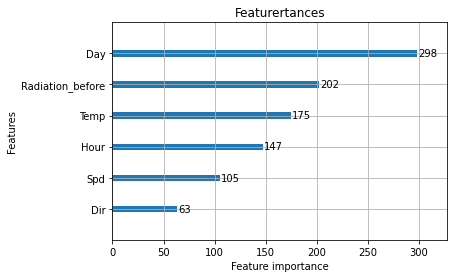

In [165]:
# Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

train_data = sunshine[0:3900].merge(temp, on=['Day', 'Hour'], how='left')
train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')

train_data['day_t'] = train_data['Day']
train_data_temp = train_data.copy()
train_data_temp['day_t'] = train_data_temp['Day'].map(lambda x: x + 7)
train_data_temp.rename(columns={'Radiation': 'Radiation_before'}, inplace=True)
train_data_temp = train_data_temp[['day_t', 'Radiation_before', 'Hour']]
train_data = train_data.merge(train_data_temp, on=['day_t', 'Hour'], how='left')


sunshine1 = sunshine.iloc[0:600, :]
sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)

# val_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')
# val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')

val_data = sunshine[3900:].merge(temp, on=['Day', 'Hour'], how='left')
val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')
val_data['day_t'] = val_data['Day']
val_data_temp = val_data.copy()
val_data_temp['day_t'] = val_data_temp['Day'].map(lambda x: x + 7)
val_data_temp.rename(columns={'Radiation': 'Radiation_before'}, inplace=True)
val_data_temp = val_data_temp[['day_t', 'Radiation_before', 'Hour']]
val_data = val_data.merge(val_data_temp, on=['day_t', 'Hour'], how='left')

features = [f for f in train_data.columns if f not in ['Radiation', 'day_t']]
# features = [f for f in train_data.columns if f not in ['Radiation', 'day_t', 'Day', 'Spd', 'Dir', 'Radiation_before']]
X_train, X_test, Y_train, Y_test = train_test_split(train_data[features], train_data['Radiation'].values, test_size=0.1, random_state=42)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 11,
    'learning_rate': 0.1,
    'metric': {'mse'},
    'verbose': -1,
    'min_data_in_leaf': 4,
    'max_depth':5
}

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# train
gbm = lgb.train(params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=30)])

# 预测提交数据                
Y_pred = gbm.predict(val_data[features])

lgb.plot_importance(gbm, max_num_features=20)
plt.title("Featurertances")
plt.show()

In [98]:
# K_fold
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

train_data = sunshine.merge(temp, on=['Day', 'Hour'], how='left')
train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')

sunshine1 = sunshine.iloc[0:150, :]
sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)

# val_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')
# val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')

val_data = sunshine[4350:].merge(temp, on=['Day', 'Hour'], how='left')
val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')

features = [f for f in train_data.columns if f not in ['Radiation', 'Day']]

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 11, 
    'learning_rate': 0.1,
    'metric': {'mse'},
    'verbose': -1,
    'min_data_in_leaf': 4,
    'max_depth':5
}

lgb_train = lgb.Dataset(train_data[features], train_data['Radiation'].values)
# train
gbm = lgb.cv(params,
             train_set=lgb_train,
             stratified=False, 
             callbacks=[lgb.early_stopping(stopping_rounds=30)])

/tmp/ipykernel_35825/3460269893.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's l2: 0.0140679 + 0.000639002


<Figure size 864x432 with 0 Axes>

0.016166817802808604

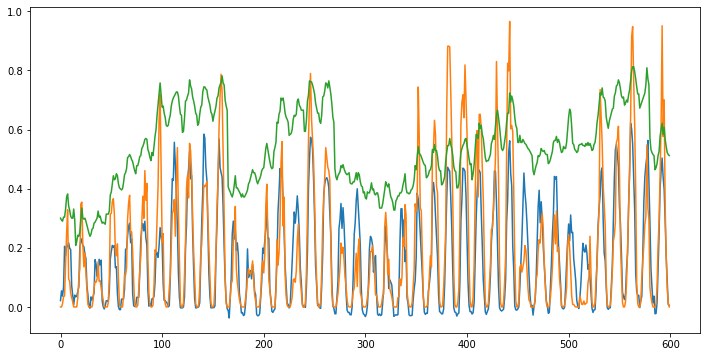

In [166]:
plt.figure(figsize=(12, 6))
plt.plot(Y_pred)
plt.plot(val_data['Radiation'])
plt.plot(val_data['Temp'])
# plt.plot(val_data['Spd'])
# plt.plot(val_data['Dir'])

from sklearn.metrics import mean_squared_error
mean_squared_error(val_data['Radiation'], Y_pred)

/tmp/ipykernel_35825/1699034353.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.015471


<Figure size 864x432 with 0 Axes>

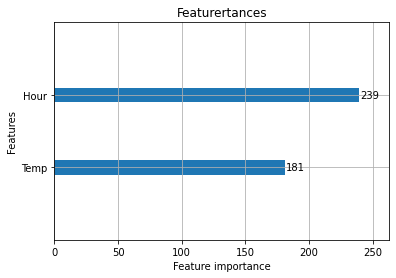

In [128]:
# Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

train_data = sunshine[0:3900].merge(temp, on=['Day', 'Hour'], how='left')
train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')

train_data['day_t'] = train_data['Day']
train_data_temp = train_data.copy()
train_data_temp['day_t'] = train_data_temp['Day'].map(lambda x: x + 10)
train_data_temp.rename(columns={'Radiation': 'Radiation_before'}, inplace=True)
train_data_temp = train_data_temp[['day_t', 'Radiation_before', 'Hour']]
train_data = train_data.merge(train_data_temp, on=['day_t', 'Hour'], how='left')


sunshine1 = sunshine.iloc[0:600, :]
sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)

# val_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')
# val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')

val_data = sunshine[3900:].merge(temp, on=['Day', 'Hour'], how='left')
val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')
val_data['day_t'] = val_data['Day']
val_data_temp = val_data.copy()
val_data_temp['day_t'] = val_data_temp['Day'].map(lambda x: x + 1)
val_data_temp.rename(columns={'Radiation': 'Radiation_before'}, inplace=True)
val_data_temp = val_data_temp[['day_t', 'Radiation_before', 'Hour']]
val_data = val_data.merge(val_data_temp, on=['day_t', 'Hour'], how='left')

features = [f for f in train_data.columns if f not in ['Radiation', 'day_t', 'Day', 'Spd', 'Dir', 'Radiation_before']]
X_train, X_test, Y_train, Y_test = train_test_split(train_data[features], train_data['Radiation'].values, test_size=0.1, random_state=42)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 11,
    'learning_rate': 0.1,
    'metric': {'mse'},
    'verbose': -1,
    'min_data_in_leaf': 4,
    'max_depth':5
}

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# train
gbm = lgb.train(params,
                train_set=lgb_train,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=30)])

# 预测提交数据                
Y_pred = gbm.predict(train_data[features])

lgb.plot_importance(gbm, max_num_features=20)
plt.title("Featurertances")
plt.show()

0.0146663062482029

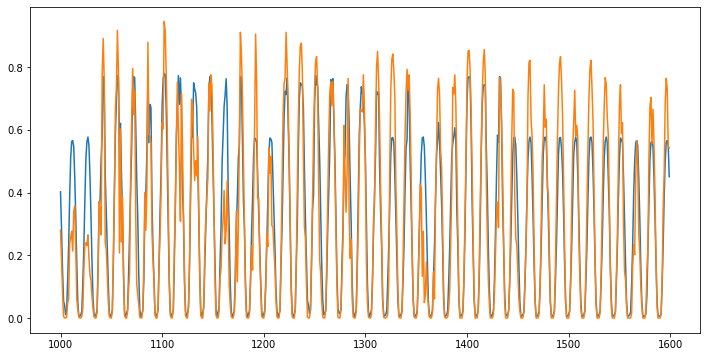

In [140]:
import numpy as np
plt.figure(figsize=(12, 6))
plt.plot(np.arange(600) + 1000, Y_pred[1000:1600])
plt.plot(train_data['Radiation'][1000:1600])
# plt.plot(train_data['Temp'][0:600])
# plt.plot(val_data['Spd'])
# plt.plot(val_data['Dir'])

from sklearn.metrics import mean_squared_error
mean_squared_error(train_data['Radiation'][1000:1600], Y_pred[1000:1600])